In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Input, Dropout, Reshape, Flatten, Conv1D, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def simple_imputation(data):
    data['date'] = pd.to_datetime(data['from date'])
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    data = data.set_index('date', drop=False)
    return data

In [3]:
raw1 = pd.read_csv("data/2018/site_1421.csv")
raw2 = pd.read_csv("data/2019/site_1421.csv")
raw3 = pd.read_csv("data/2020/site_1421.csv")

In [4]:
raw = pd.concat([raw1,raw2, raw3])

In [5]:
data = simple_imputation(raw)

In [6]:
n_steps = 3
n_features = 1
out_steps = 1

In [8]:
tmp19 = data.resample('H').max()[['PM2.5', 'PM10', 'NO2','NH3', 'SO2', 'CO', 'Ozone']]

### Normalization

In [13]:
#for col in tmp19.columns:
#    tmp19[col] = np.log(tmp19[col], where=(tmp19[col] > 0))

In [9]:
train_mean = tmp19.mean()
train_std = tmp19.std()

tmp19 = (tmp19 - train_mean) / train_std

In [10]:
def split_into_sequence(df, in_steps, out_steps):
    n = df.shape[0]
    in_start = 0
    X, y = list(), list()
    for _ in range(n):
        in_end = in_start + in_steps
        out_end = in_end + out_steps
    
        if out_end < n:
            feature = df[in_start:in_end].values
            feature = feature.reshape(feature.shape[0]*feature.shape[1], 1)
            label = df[in_end:out_end].values
            label = label.reshape(label.shape[0]*label.shape[1])
            X.append(feature)
            y.append(label)
        in_start += 1
    return np.array(X), np.array(y)

In [11]:
in_steps, out_steps = 24*3, 24*2

In [12]:
X, y = split_into_sequence(tmp19, in_steps, out_steps)

In [13]:
n = X.shape[0]

Xtrain = X[0:int(n*0.7)]
Ytrain = y[0:int(n*0.7)]

Xval = X[int(n*0.7):int(n*0.9)]
Yval = y[int(n*0.7):int(n*0.9)]

Xtest = X[int(n*0.9):]
Ytest = y[int(n*0.9):]

In [247]:
adam = tf.keras.optimizers.Adam(clipvalue=0.2)

In [320]:
model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(Flatten())
model.add(Dense(out_steps*7))
model.add(Dropout(0.3))
model.add(Dense(out_steps*7))
model.compile(loss='mae', optimizer=adam)

In [321]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 504, 128)          66560     
_________________________________________________________________
time_distributed_27 (TimeDis (None, 504, 64)           8256      
_________________________________________________________________
flatten_4 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 336)               10838352  
_________________________________________________________________
dropout_4 (Dropout)          (None, 336)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 336)               113232    
Total params: 11,026,400
Trainable params: 11,026,400
Non-trainable params: 0
_________________________________________

In [322]:
model.evaluate(Xval, Yval)

144/144 [==============================] - 29s 205ms/step - loss: 0.7059


0.705946683883667

In [325]:
model_path = "deepAR_10132020_v3.h5"
callbacks = [ EarlyStopping(monitor='val_loss', patience=10, verbose=0),
            ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=0)]

In [326]:
model.fit(Xtrain, Ytrain, validation_data=(Xval, Yval), epochs=10, batch_size=64, callbacks=callbacks)

Epoch 1/10
252/252 [==============================] - 309s 1s/step - loss: 0.3922 - val_loss: 0.4537
Epoch 2/10
252/252 [==============================] - 334s 1s/step - loss: 0.3909 - val_loss: 0.4514
Epoch 3/10
252/252 [==============================] - 302s 1s/step - loss: 0.3892 - val_loss: 0.4479
Epoch 4/10
252/252 [==============================] - 286s 1s/step - loss: 0.3855 - val_loss: 0.4490
Epoch 5/10
252/252 [==============================] - 286s 1s/step - loss: 0.3839 - val_loss: 0.4510
Epoch 6/10
252/252 [==============================] - 289s 1s/step - loss: 0.3817 - val_loss: 0.4575
Epoch 7/10
252/252 [==============================] - 285s 1s/step - loss: 0.3792 - val_loss: 0.4533
Epoch 8/10
252/252 [==============================] - 278s 1s/step - loss: 513316624153968640.0000 - val_loss: 0.4548
Epoch 9/10
252/252 [==============================] - 293s 1s/step - loss: 0.3852 - val_loss: 0.4510
Epoch 10/10
252/252 [==============================] - 236s 937ms/step - l

In [52]:
pred = model.predict(Xtest)

In [53]:
test_df = pd.DataFrame(Ytest.reshape(2309, 7), columns=tmp19.columns)
pred_df = pd.DataFrame(pred.reshape(2309, 7), columns=tmp19.columns)

In [54]:
test_df = (test_df *train_std) + train_mean
pred_df = (pred_df *train_std) + train_mean

In [55]:
# Mean Absolute Percentage Error
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [56]:
for col in test_df.columns:
    print("% , MAE is --> % and MAPE is --> % ", (col, mean_absolute_error(test_df[col], pred_df[col]), mape(test_df[col], pred_df[col])))

% , MAE is --> % and MAPE is --> %  ('PM2.5', 4.610167555549506, 22.325394505307063)
% , MAE is --> % and MAPE is --> %  ('PM10', 14.176490618932409, 21.549889064041285)
% , MAE is --> % and MAPE is --> %  ('NO2', 6.493342057343594, 58.19623710820688)
% , MAE is --> % and MAPE is --> %  ('NH3', 3.452611641794534, 14.040906013962745)
% , MAE is --> % and MAPE is --> %  ('SO2', 1.4206371058727822, 19.755154089256116)
% , MAE is --> % and MAPE is --> %  ('CO', 0.1190744981640998, 15.963858135866207)
% , MAE is --> % and MAPE is --> %  ('Ozone', 11.778750825779728, 21.97377294504802)


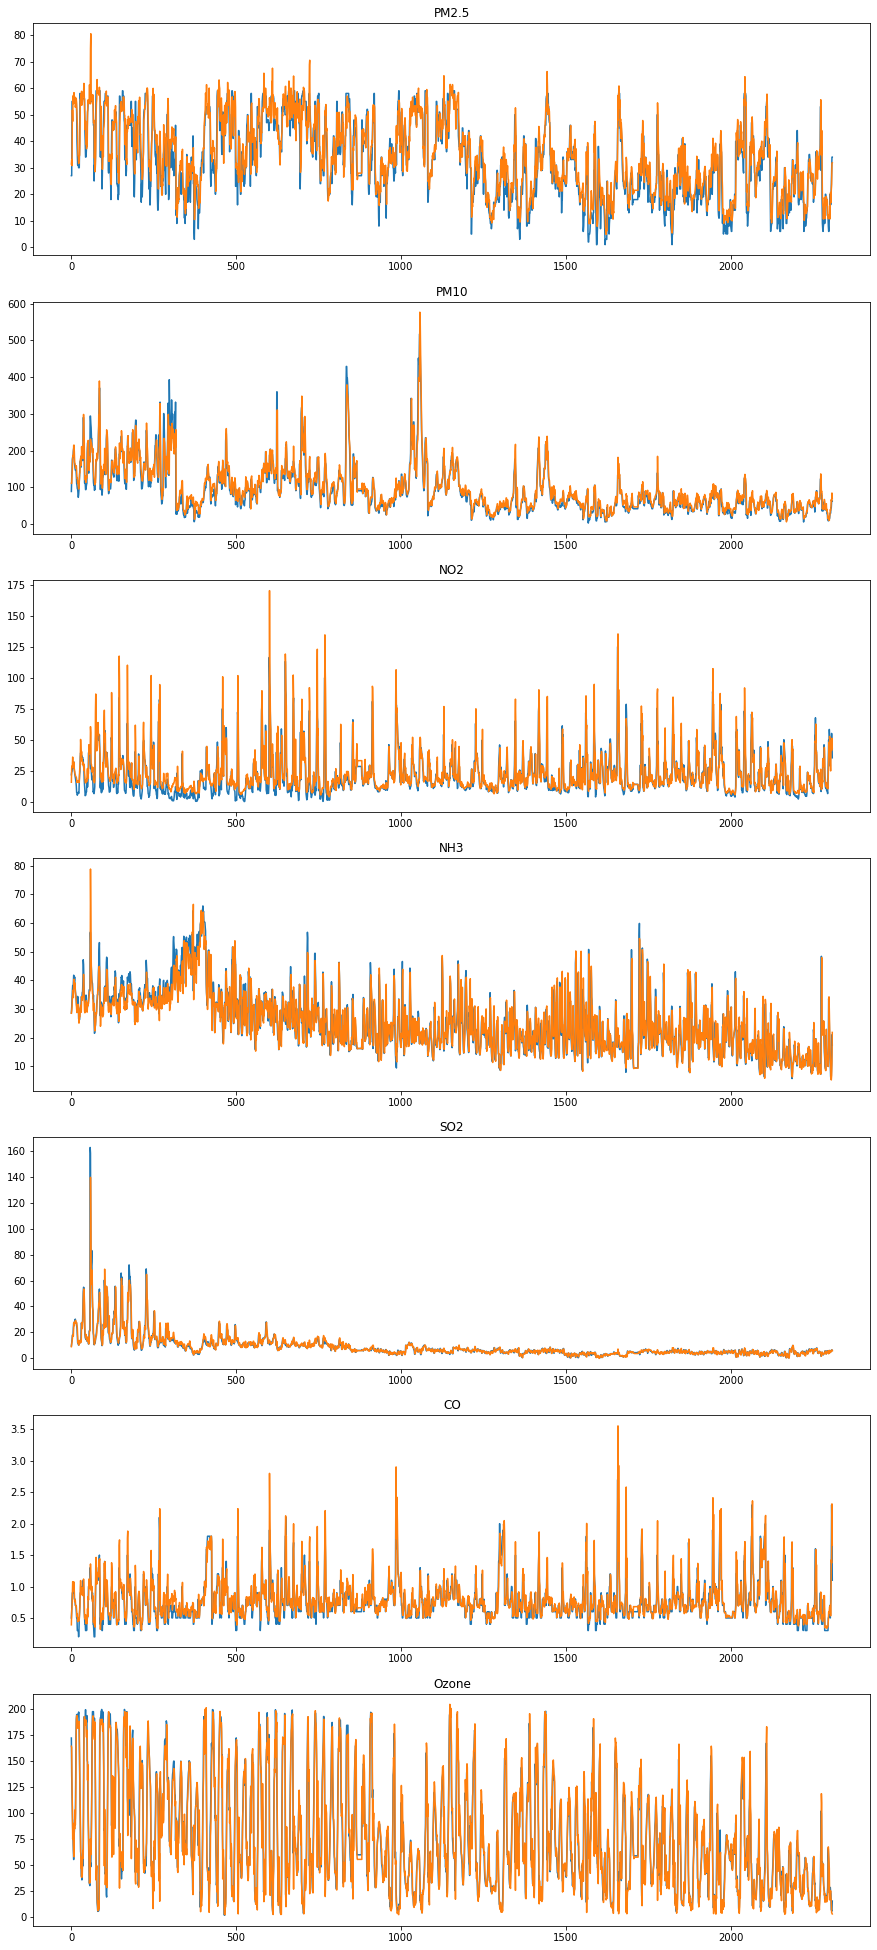

In [58]:
f, a = plt.subplots(7, 1, figsize=(15, 35))
i = 0
for col in test_df.columns:
    a[i].plot(test_df[col])
    a[i].plot(pred_df[col])
    a[i].set_title(col)
    i +=1

In [68]:
dict(zip(train_mean.index.tolist(), train_mean.values))
dict(zip(train_std.index.tolist(), train_std.values))
#print(train_std)

{'PM2.5': 85.34530092297388,
 'PM10': 134.4356549774331,
 'NO2': 46.97229081816195,
 'NH3': 19.14264948364451,
 'SO2': 15.334984288350336,
 'CO': 1.0452335838858684,
 'Ozone': 52.481729914589465}

In [69]:
meanT = {'PM2.5': 82.44984667359671,
 'PM10': 190.99442264379766,
 'NO2': 50.17874177061667,
 'NH3': 29.36928750866255,
 'SO2': 20.01511347886375,
 'CO': 1.2961534130284147,
 'Ozone': 46.68574887387314}

stdT = {'PM2.5': 85.34530092297388,
 'PM10': 134.4356549774331,
 'NO2': 46.97229081816195,
 'NH3': 19.14264948364451,
 'SO2': 15.334984288350336,
 'CO': 1.0452335838858684,
 'Ozone': 52.481729914589465}

In [72]:
smodel = tf.keras.models.load_model("deepAR_10132020.h5")

In [230]:
start_date = '2020-08-20'
to_date = '2020-08-30'
to_date = (datetime.strptime(to_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')

In [222]:
from datetime import datetime
from datetime import timedelta

In [225]:
to_date = (datetime.strptime(to_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')

'2020-08-31'

In [231]:
index = pd.date_range(start=start_date, end=to_date, freq='H')

In [232]:
n = len(index)

In [238]:
index[-25:-1]

DatetimeIndex(['2020-08-30 00:00:00', '2020-08-30 01:00:00',
               '2020-08-30 02:00:00', '2020-08-30 03:00:00',
               '2020-08-30 04:00:00', '2020-08-30 05:00:00',
               '2020-08-30 06:00:00', '2020-08-30 07:00:00',
               '2020-08-30 08:00:00', '2020-08-30 09:00:00',
               '2020-08-30 10:00:00', '2020-08-30 11:00:00',
               '2020-08-30 12:00:00', '2020-08-30 13:00:00',
               '2020-08-30 14:00:00', '2020-08-30 15:00:00',
               '2020-08-30 16:00:00', '2020-08-30 17:00:00',
               '2020-08-30 18:00:00', '2020-08-30 19:00:00',
               '2020-08-30 20:00:00', '2020-08-30 21:00:00',
               '2020-08-30 22:00:00', '2020-08-30 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [214]:
np.save('last_input.npy', Xtest[-1].reshape(1,21,1))

In [215]:
np.load('last_input.npy')

array([[[-0.6965802 ],
        [-1.08597993],
        [-0.05489921],
        [-1.18422936],
        [-0.959578  ],
        [ 0.09935252],
        [-0.75618218],
        [-0.61456045],
        [-0.96696388],
        [ 0.1068983 ],
        [-0.9804958 ],
        [-0.89436763],
        [ 0.96040407],
        [-0.76761473],
        [-0.56769202],
        [-0.95208688],
        [-0.02935224],
        [-0.43720633],
        [-0.90088866],
        [ 0.57771449],
        [-0.77714185]]])

In [205]:
last_input = Xtest[-1].reshape(1,21,1)
predictions = []
for i in range(n):
    first_output = smodel.predict(last_input)
    predictions.append(first_output.tolist()[0])
    last2rec  = last_input[0][-14:].tolist()
    last2rec.extend(first_output.tolist()[0])
    last_input = np.array(last2rec).reshape(1,21,1)

In [206]:
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

In [207]:
pred_df = pd.DataFrame(predictions, columns=tmp19.columns, index = index)

In [209]:
pred_df = (pred_df * list(stdT.values())) + list(meanT.values())

In [242]:
pred_df[-25:-1]

,PM2.5,PM10,NO2,NH3,SO2,CO,Ozone
2020-08-29 00:00:00,44.113528,72.358580,25.690378,24.083224,21.290958,0.935680,3.997643
2020-08-29 01:00:00,44.113531,72.358572,25.690381,24.083224,21.290958,0.935681,3.997643
2020-08-29 02:00:00,44.113528,72.358572,25.690375,24.083223,21.290957,0.935681,3.997643
2020-08-29 03:00:00,44.113533,72.358580,25.690375,24.083224,21.290955,0.935681,3.997643
2020-08-29 04:00:00,44.113528,72.358588,25.690375,24.083221,21.290959,0.935681,3.997640
2020-08-29 05:00:00,44.113538,72.358580,25.690383,24.083222,21.290960,0.935681,3.997637
2020-08-29 06:00:00,44.113528,72.358572,25.690386,24.083223,21.290959,0.935680,3.997637
2020-08-29 07:00:00,44.113526,72.358572,25.690381,24.083222,21.290959,0.935680,3.997637
2020-08-29 08:00:00,44.113528,72.358564,25.690392,24.083222,21.290958,0.935680,3.997640
2020-08-29 09:00:00,44.113523,72.358572,25.690383,24.083219,21.290959,0.935680,3.997643


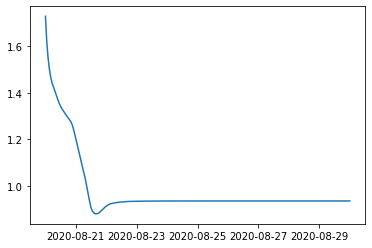

In [212]:
plt.plot(pred_df['CO'])

In [178]:
list(meanT.values())

[82.44984667359671,
 190.99442264379766,
 50.17874177061667,
 29.36928750866255,
 20.01511347886375,
 1.2961534130284147,
 46.68574887387314]

In [169]:
np.array(predictions).shape

(5, 7, 1)

# Long Sequence Generation Model test

In [14]:
ls_model = tf.keras.models.load_model("deepAR_10132020_v3.h5")

In [24]:
pred = ls_model.predict(Xtest[:1])

In [43]:
pred_df = pd.DataFrame(pred[0].reshape(int(pred[0].shape[0]/7), 7), columns=tmp19.columns)

In [46]:
pred_df = ((pred_df * train_std) + train_mean)

In [50]:
act_df = pd.DataFrame(Xtest[1:2][0].reshape(int(Xtest[1:2][0].shape[0]/7), 7), columns=tmp19.columns)

In [51]:
act_df = ((act_df * train_std) + train_mean)

In [58]:
act_df = act_df[24:].reset_index()

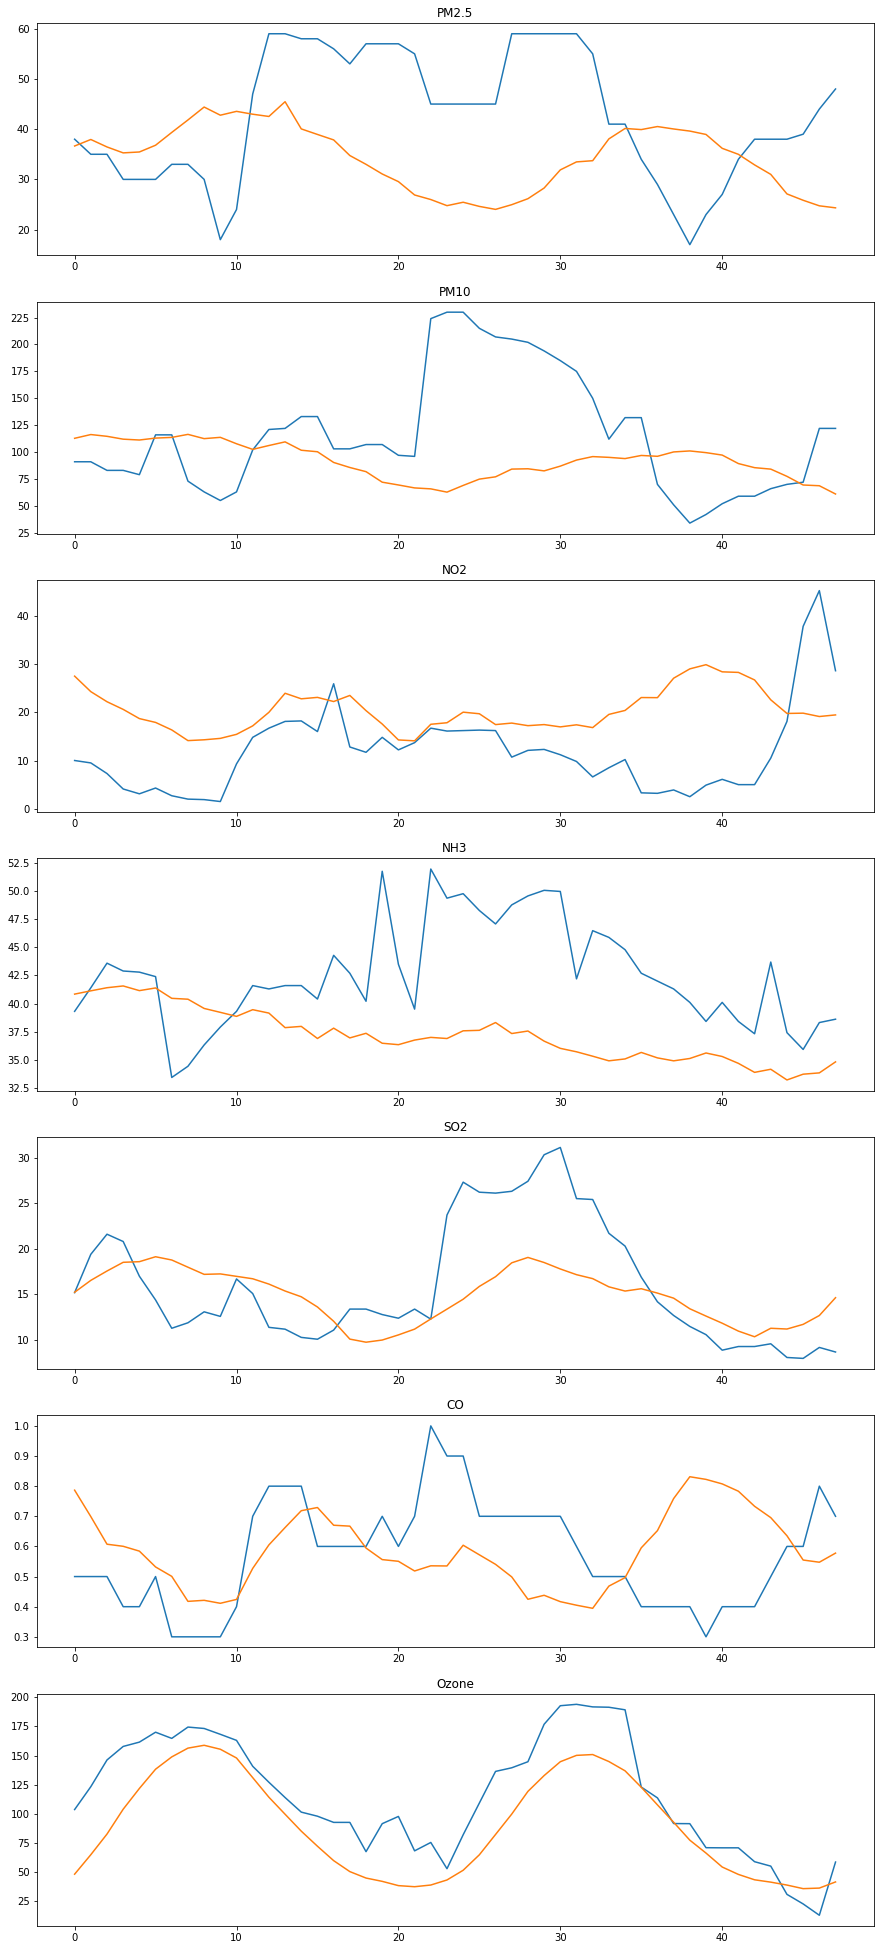

In [63]:
f, a = plt.subplots(7, 1, figsize=(15, 35))
i = 0
for col in act_df.columns:
    a[i].plot(act_df[col])
    a[i].plot(pred_df[col])
    a[i].set_title(col)
    i +=1